In [1]:
import healpy as h
import sys  ; sys.path.append("../../codes/")
from modules import local_eb_kernel_masked as rk
from scipy.integrate import quad
import timeit
from scipy.interpolate import interp1d

%pylab notebook
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
nside=128 ; ell=arange(3*nside+1) ; upnside=1*nside ; npix=h.nside2npix(upnside) ; print npix
beta0=min(180,180*24./(3.*nside)) ; xsize=400 ; reso=1.5*beta0*60./xsize ; print beta0
betafull=180.
y=rk.real_space_queb_kernels(nside,tmax=betafull,maxlmax=3*nside,sampling=2500)

196608
11.25


In [3]:
lmin=2; lmax=2*nside ; beta0=min(180,180*24./(lmax)) ; print beta0
fl=ones(3*nside+1,double)
fl[:lmin]=0 ; fl[lmax+1:]=0

wl=np.sqrt(double(2.*ell+1.)/(double(4.)*pi))*y.omega*double(0.5)*double(fl)

y.calc_qu2eb_rad_kernel(lmax,lmin)
y.calc_qu2queb_rad_kernel(lmin,lmin)
y.setup_fn_rad_ker()

16.875


In [4]:
rmr=zeros(h.nside2npix(nside),float)
rmi=zeros(h.nside2npix(nside),float)
almr0=h.map2alm(rmr,lmax=lmax,mmax=lmax)
almi0=h.map2alm(rmi,lmax=lmax,mmax=lmax)
almsize=h.Alm.getsize(lmax,lmax)
for i in range(almsize):
    l,m=h.Alm.getlm(lmax,i)
    #if l>1 and m==2:
    if m==2:
        almr0[i]=complex(double(1.),double(0.))*wl[l]
        almi0[i]=complex(double(0.),double(1.))*wl[l]
rmr0=h.alm2map(almr0,nside,lmax=lmax,mmax=lmax,verbose=False)
rmi0=h.alm2map(almi0,nside,lmax=lmax,mmax=lmax,verbose=False)

def return_ker(nside,theta,phi):
    almr=zeros(almsize,complex) ; almi=zeros(almsize,complex)
    almr[:]=almr0[:] ; almi[:]=almi0[:]
    h.rotate_alm(almr,0.,theta*pi/double(180.),phi*pi/double(180.),lmax=lmax)
    h.rotate_alm(almi,0.,theta*pi/double(180.),phi*pi/double(180.),lmax=lmax)
    rmr=h.alm2map(almr,nside)
    rmi=h.alm2map(almi,nside)
    return rmr,rmi

In [5]:
theta0=2. ; phi0=0.
cpix=h.ang2pix(upnside,theta0*pi/180.,phi0*pi/180.) ; print cpix
theta,phi=h.pix2ang(upnside,cpix)
theta=theta*180./pi ; phi=phi*180/pi ; print theta,phi

tqu=[zeros(npix,float),zeros(npix,float),zeros(npix,float)] ; tqu[1][cpix]=1.
alm=h.map2alm(tqu,lmax=lmax,pol=True,iter=0) ; alm=[h.almxfl(alm[i],fl,inplace=True) for i in arange(3)]
rtquq=h.alm2map(alm,upnside,pol=True,verbose=False)
tebq=h.alm2map(alm,upnside,pol=False,verbose=False)

tqu=[zeros(npix,float),zeros(npix,float),zeros(npix,float)] ; tqu[2][cpix]=1.
alm=h.map2alm(tqu,lmax=lmax,pol=True,iter=0) ; alm=[h.almxfl(alm[i],fl,inplace=True) for i in arange(3)]
rtquu=h.alm2map(alm,upnside,pol=True,verbose=False)
tebu=h.alm2map(alm,upnside,pol=False,verbose=False)

60
2.19303111936 7.5


In [6]:
mr=zeros(npix,float) ; mi=zeros(npix,float) ; fb=zeros(npix,float)
mrp=zeros(npix,float) ; mip=zeros(npix,float)
norm=(nside**2.)/(upnside**2.) ; print norm
a,b,g,pix2=y.return_euler_angles(upnside,cpix,betafull)
mr[pix2]=mr[pix2] + cos(2.*a)*y.fn_rad_ker(b)*norm ; mi[pix2]= mi[pix2] + sin(2.*a)*y.fn_rad_ker(b)*norm
mrp[pix2]=mrp[pix2] + cos(2.*g)*y.fn_rad_ker(b)*norm ; mip[pix2]= mip[pix2] + sin(2.*g)*y.fn_rad_ker(b)*norm
fb=y.fn_rad_ker(b)

rmr,rmi=return_ker(nside,theta,phi)
#rteb=y.convert_qu2eb(tqu,discsize=45.)

1.0
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


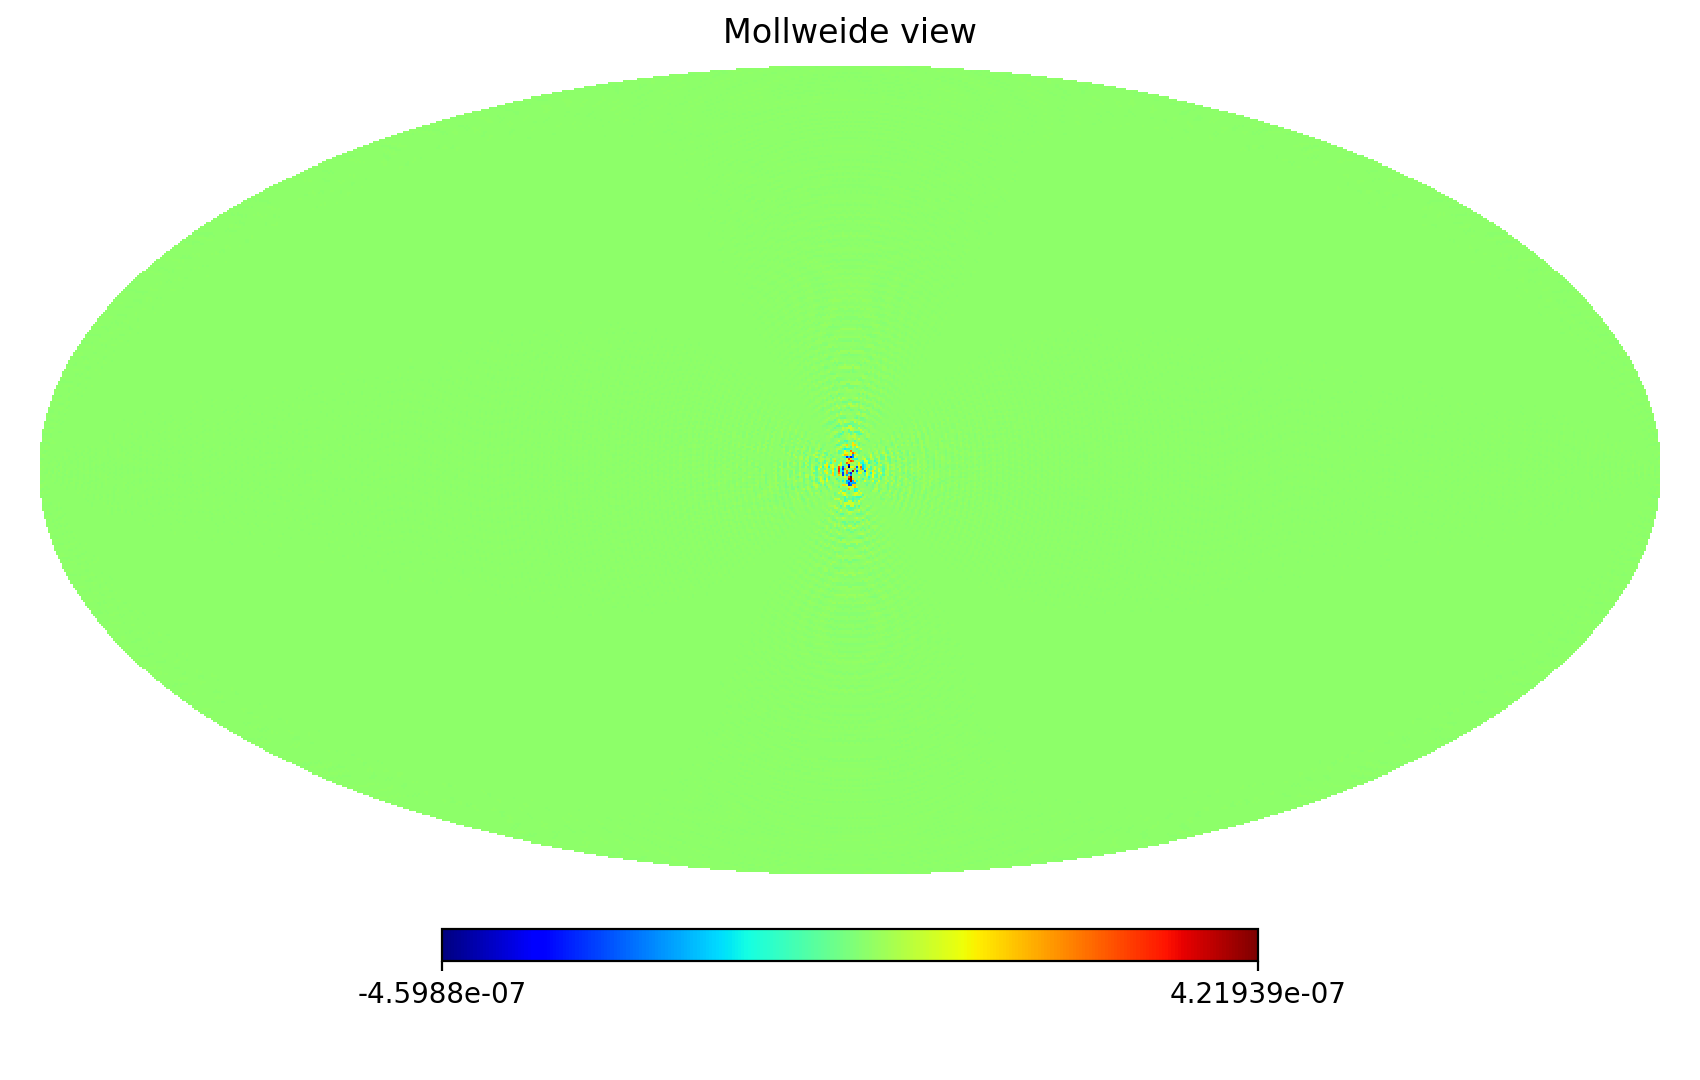

<IPython.core.display.Javascript object>


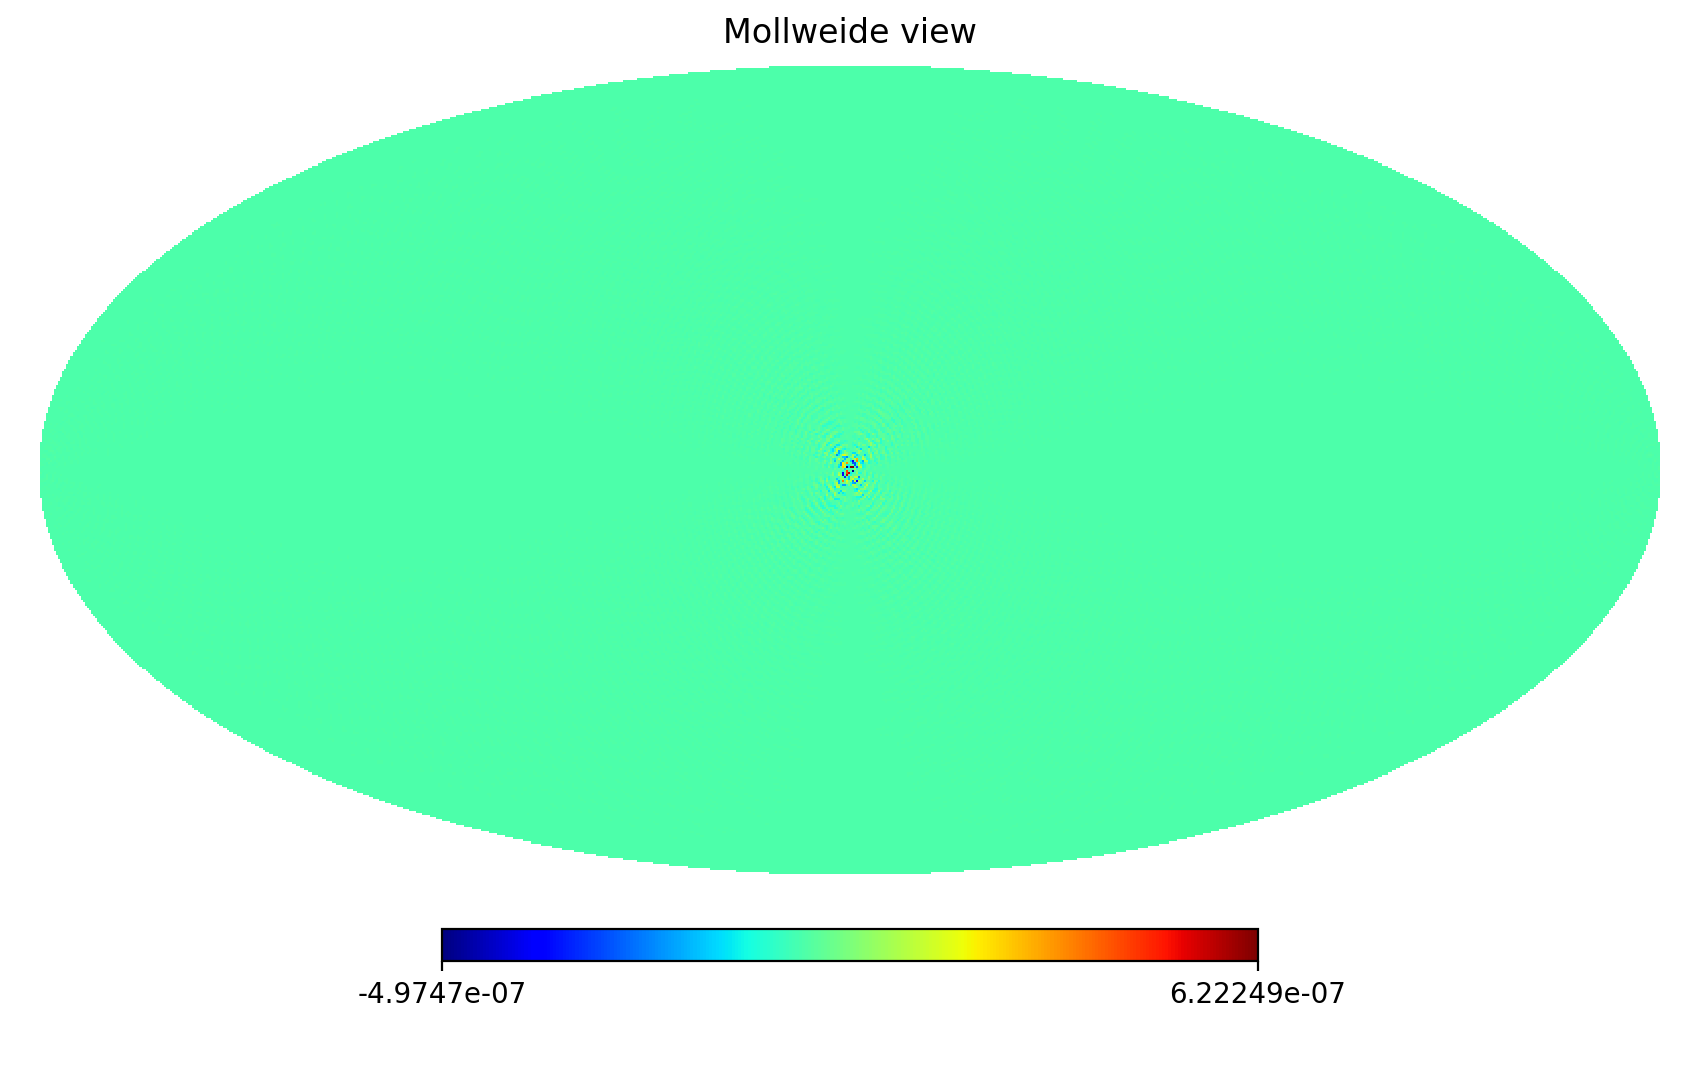

In [8]:
h.mollview(tebu[2]+mr,rot=(phi,90-theta))
h.mollview(tebq[2]+mi,rot=(phi,90-theta))

<IPython.core.display.Javascript object>


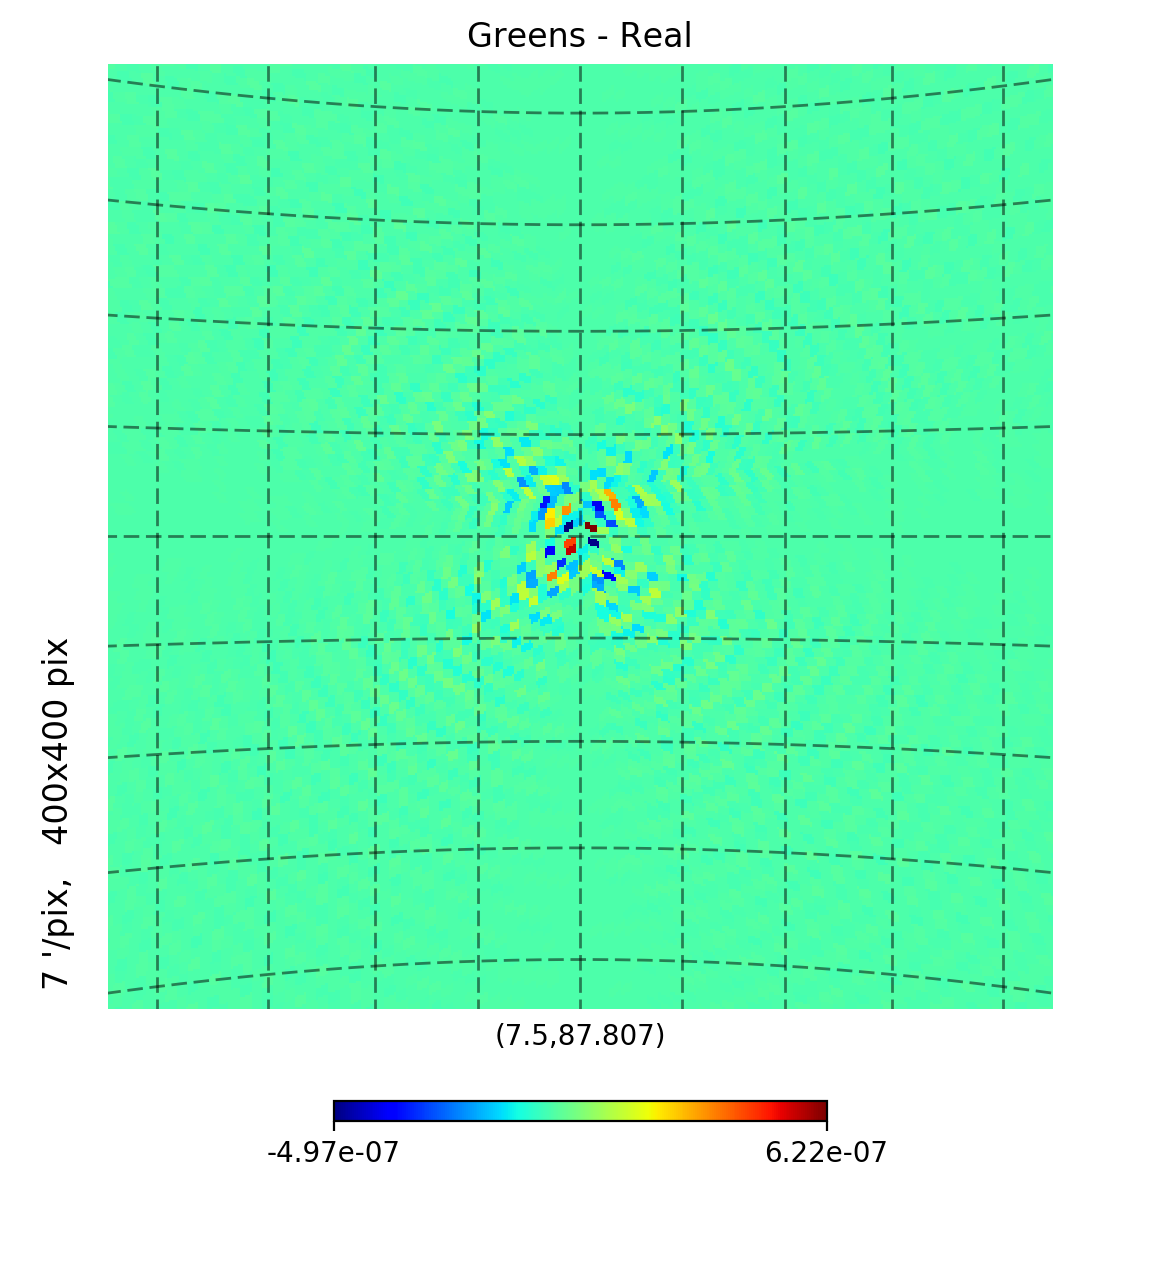

60.1230870836 119.876912916 -29.8769129164 29.8769129164
The interval between parallels is 5 deg 0.00'.
The interval between meridians is 5 deg 0.00'.


<IPython.core.display.Javascript object>


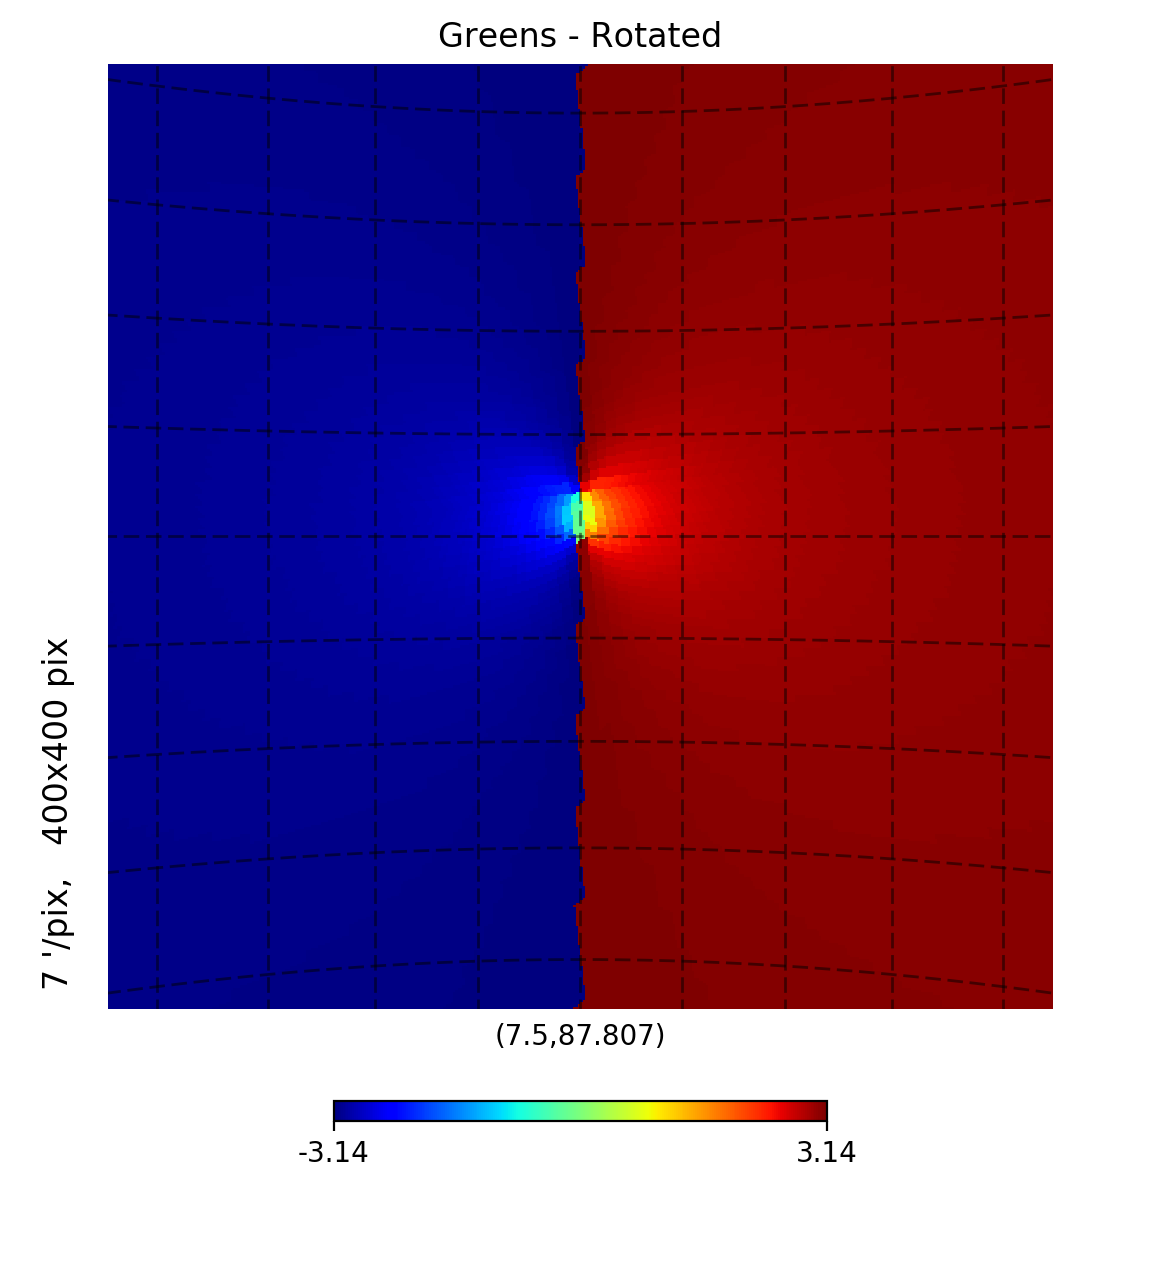

60.1230870836 119.876912916 -29.8769129164 29.8769129164
The interval between parallels is 5 deg 0.00'.
The interval between meridians is 5 deg 0.00'.


<IPython.core.display.Javascript object>


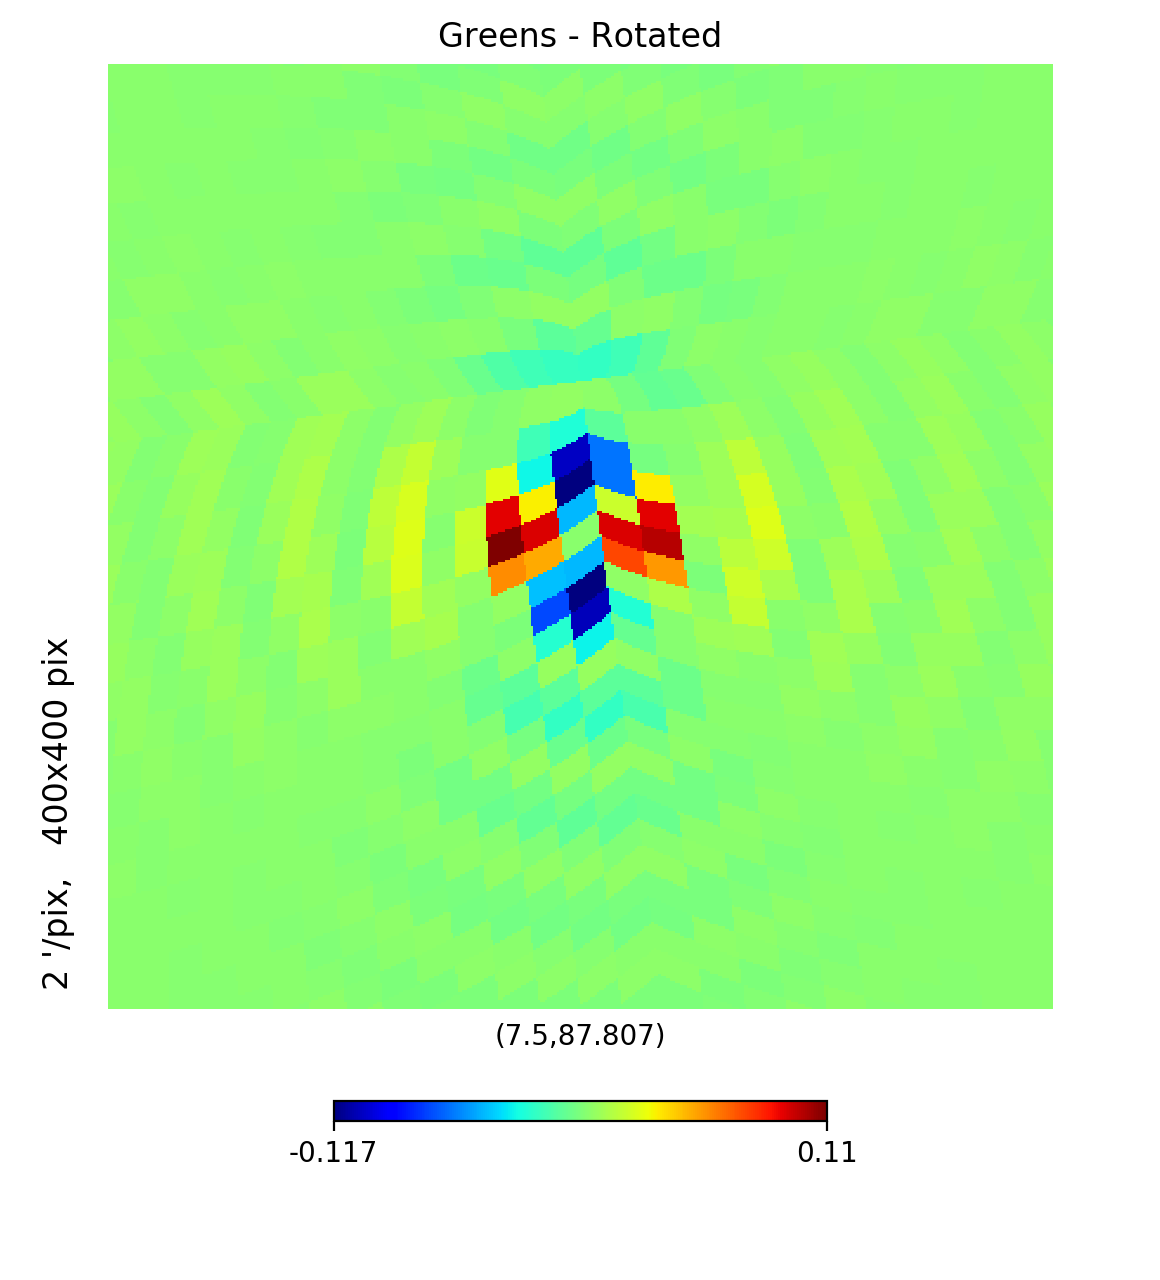

<IPython.core.display.Javascript object>


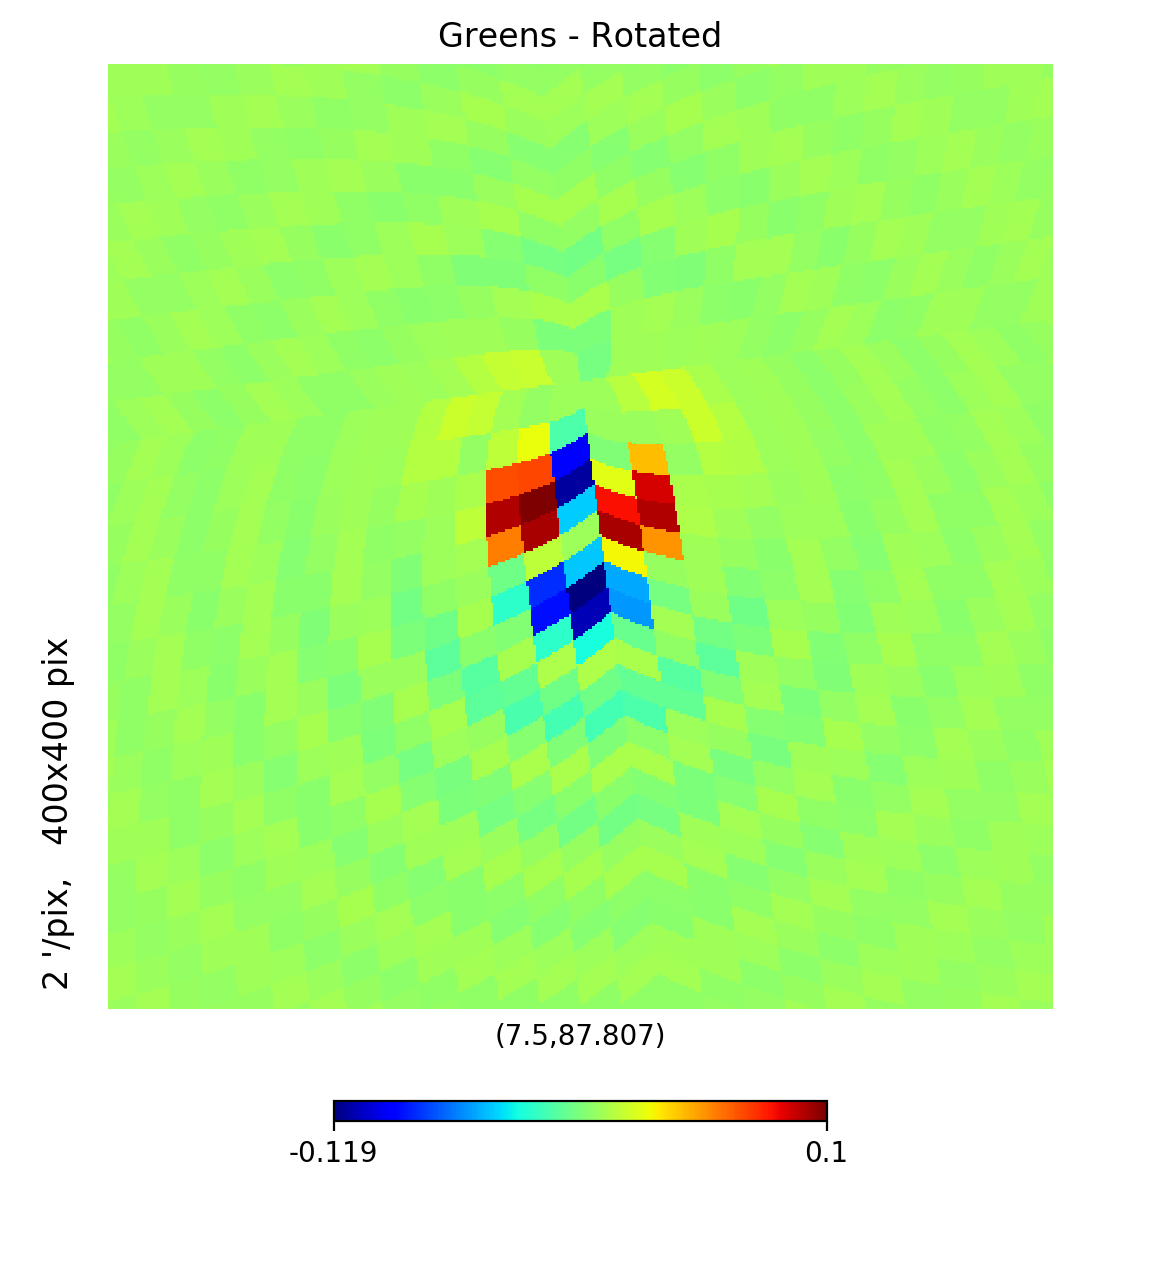

<IPython.core.display.Javascript object>


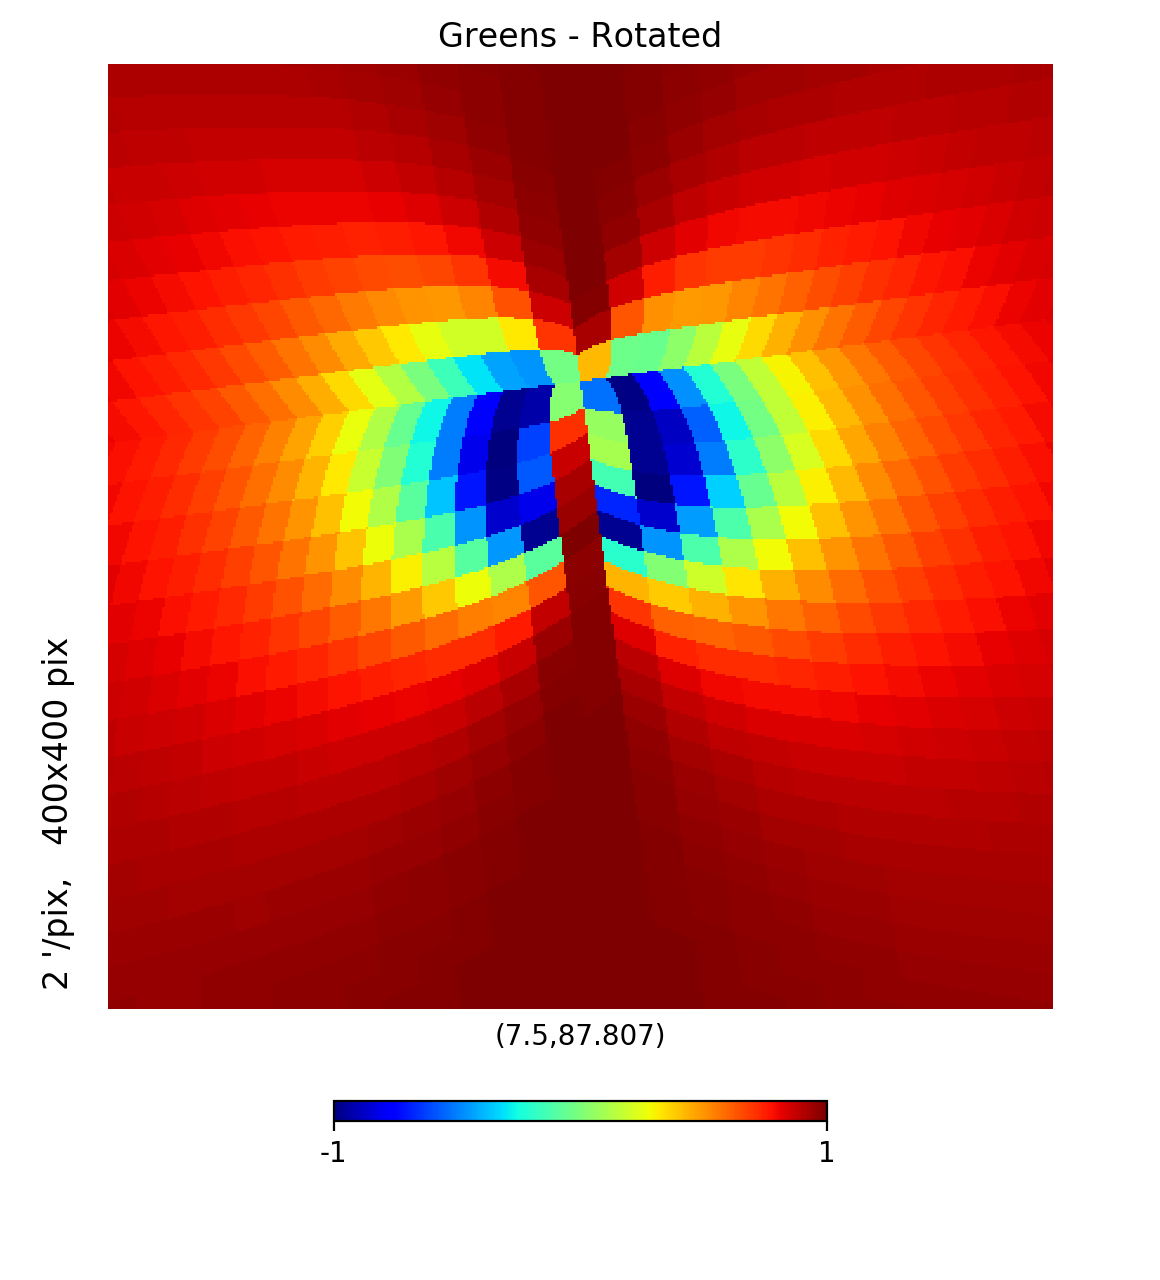

In [9]:
h.gnomview(tebq[2]+mi,rot=(phi,90-theta),xsize=400,reso=7,title="Greens - Real")
h.graticule(dpar=5,dmer=5,ls="dashed",alpha=0.5)
h.gnomview(g,rot=(phi,90-theta),xsize=400,reso=7,title="Greens - Rotated")
h.graticule(dpar=5,dmer=5,ls="dashed",alpha=0.5)
#h.gnomview(-cos(2.*g),rot=(phi,90-theta),xsize=400,reso=2,title="Greens - Rotated")
h.gnomview(-mr,rot=(phi,90-theta),xsize=400,reso=2,title="Greens - Rotated")
h.gnomview(-cos(2.*g)*y.fn_rad_ker(b)*norm,rot=(phi,90-theta),xsize=400,reso=2,title="Greens - Rotated")
h.gnomview(-cos(2.*(pi/2.-g)),rot=(phi,90-theta),xsize=400,reso=2,title="Greens - Rotated")

In [342]:
theta0=5. ; phi0=0.
cpix=h.ang2pix(upnside,theta0*pi/180.,phi0*pi/180.) #; print cpix
theta,phi=h.pix2ang(upnside,cpix)
theta=theta*180./pi ; phi=phi*180/pi ; print theta,phi

tqu=[zeros(npix,float),zeros(npix,float),zeros(npix,float)] ; tqu[1][cpix]=1.
alm=h.map2alm(tqu,lmax=lmax,pol=True,iter=10) ; alm=[h.almxfl(alm[i],fl,inplace=True) for i in arange(3)]
tebq=h.alm2map(alm,upnside,pol=False,verbose=False)

mr=zeros(npix,float) ; mi=zeros(npix,float) ; fb=zeros(npix,float)
norm=(nside**2.)/(upnside**2.) #; print norm
a,b,g,pix2=y.return_euler_angles(upnside,cpix,betafull)
mr[pix2]=mr[pix2] + cos(2.*a)*y.fn_rad_ker(b)*norm ; mi[pix2]= mi[pix2] + sin(2.*a)*y.fn_rad_ker(b)*norm
fb=y.fn_rad_ker(b)

rmr,rmi=return_ker(nside,theta,phi)

y1=tebq[1]**2. + tebq[2]**2.
y2=mr**2. + mi**2. #; y2[cpix]=1.
ry2=rmr**2. + rmi**2. #; y2[cpix]=1.
r= max(y1)/max(ry2) ; print r

5.11846209777 3.21428571429
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.999927994891


<IPython.core.display.Javascript object>


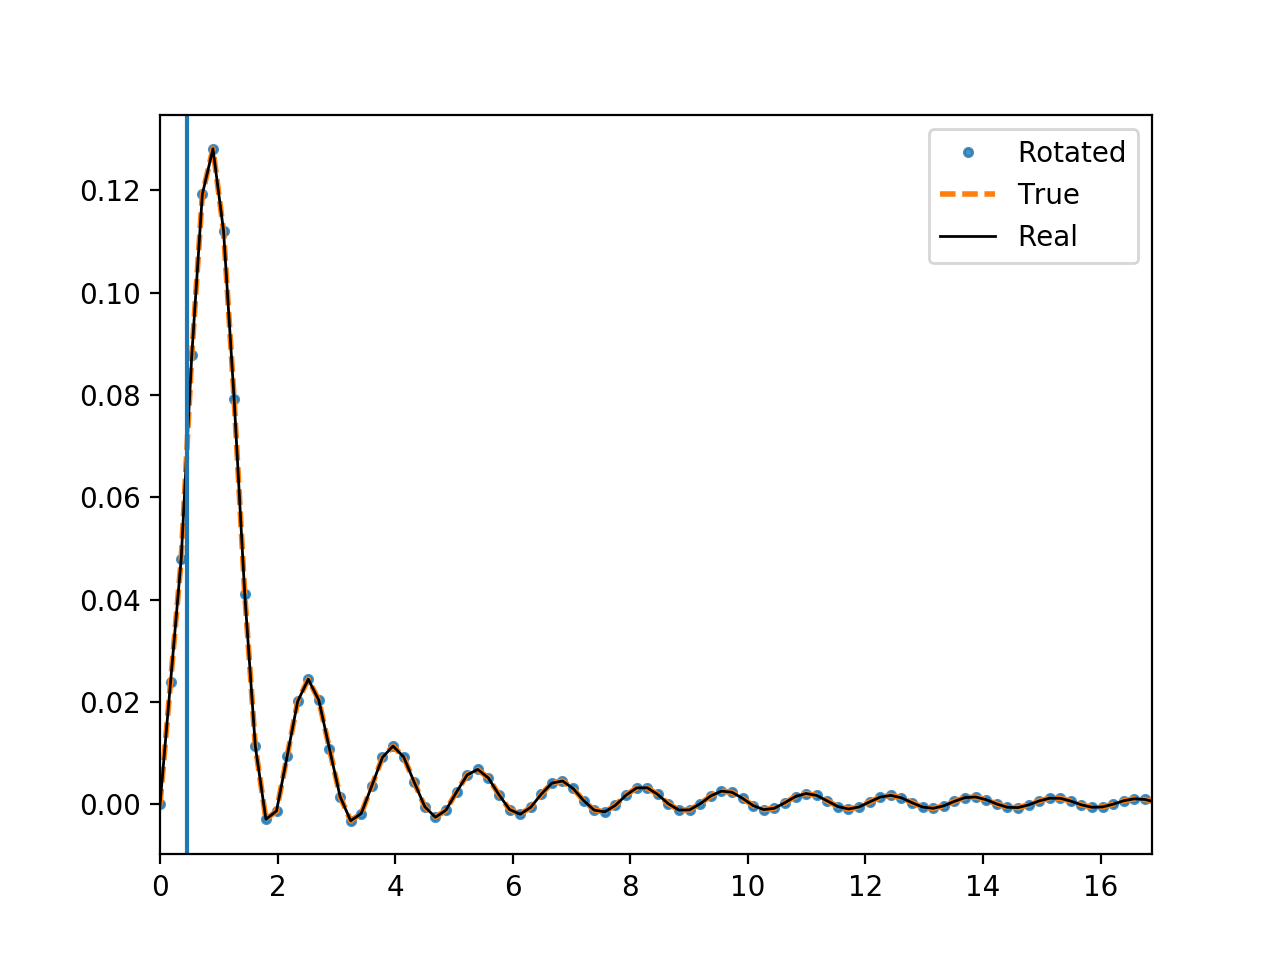

<IPython.core.display.Javascript object>


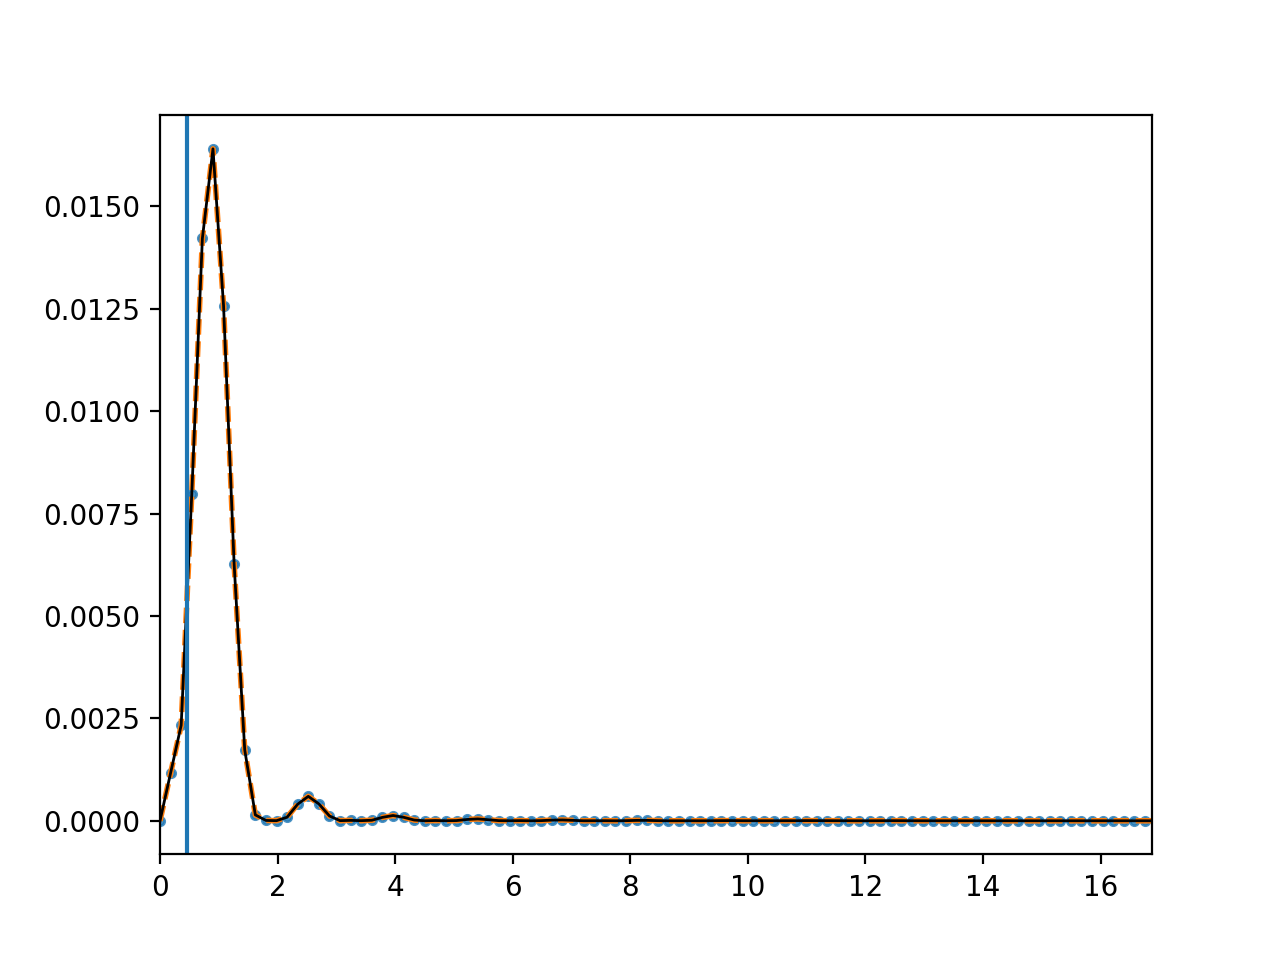

<IPython.core.display.Javascript object>


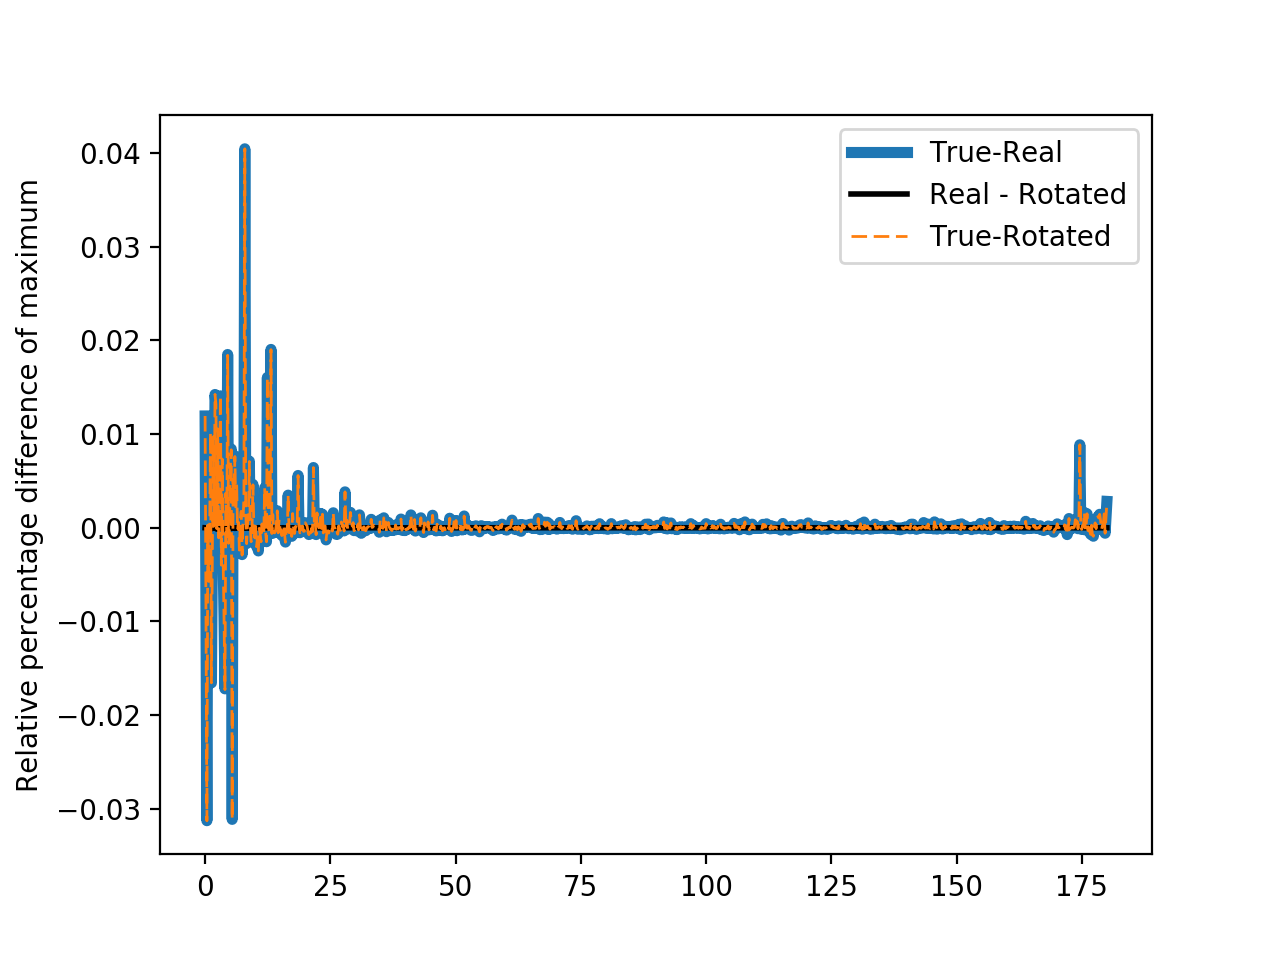

In [346]:
fny1=interp1d(b,sqrt(y1),bounds_error=None, fill_value=0.)
fnsqy1=interp1d(b,y1,bounds_error=None, fill_value=0.)

fnry2=interp1d(b,sqrt(ry2),bounds_error=None, fill_value=0.)
fnsqry2=interp1d(b,ry2,bounds_error=None, fill_value=0.)

z=mr**2. + mi**2.
fnz=interp1d(b,sqrt(z),bounds_error=None, fill_value=0.)
fnsqz=interp1d(b,z,bounds_error=None, fill_value=0.)

btheta=linspace(min(b),max(b),1000)

figure()

plot(btheta*180./pi,fnry2(btheta)*sign(y.fn_rad_ker(btheta)),".",alpha=0.8,label="Rotated")
plot(btheta*180./pi,fny1(btheta)*sign(y.fn_rad_ker(btheta)),"--",lw=2,alpha=1.,label="True")
plot(btheta*180./pi,fnz(btheta)*sign(y.fn_rad_ker(btheta)),"k-",lw=1,alpha=1.,label="Real")
legend(loc=0)
xlim(1e-2,220)
axvline(sqrt(4.*pi/npix)*180./pi)
xlim(0,beta0)
#xlim(0,30)
#loglog()

figure()
plot(btheta*180./pi,fnsqry2(btheta),".",alpha=0.8,label="Rotated")
plot(btheta*180./pi,fnsqy1(btheta),"--",lw=2,alpha=1.,label="True")
plot(btheta*180./pi,fnsqz(btheta),"k-",lw=1,alpha=1.,label="Real")
axvline(sqrt(4.*pi/npix)*180./pi)
xlim(0,beta0)
#xlim(0,30)
#legend(loc=0)
#semilogy()

rconvert=100./max(fny1(btheta))
figure()
#plot(btheta*180./pi,(fny1(btheta)-fnz(btheta))*100/fny1(btheta),"-",lw=4,alpha=1.,label="True-Real")
#plot(btheta*180./pi,(fnry2(btheta)-fnz(btheta))*100/fny1(btheta),"k-",lw=2,alpha=1.,label="Rotated - Real")
plot(btheta*180./pi,(fny1(btheta)-fnz(btheta))*rconvert,"-",lw=4,alpha=1.,label="True-Real")
plot(btheta*180./pi,(fnz(btheta)-fnry2(btheta))*rconvert,"k-",lw=2,alpha=1.,label="Real - Rotated")
plot(btheta*180./pi,(fny1(btheta)-fnry2(btheta))*rconvert,"--",lw=1,alpha=1.,label="True-Rotated")
#plot(btheta*180./pi,(fnry2(btheta))*2e2,"--",lw=1,alpha=1.,label="True-Rotated")
#ylim(-10.,10.)
ylabel("Relative percentage difference of maximum")
legend(loc=0)
#xlim(0,beta0)
#xlim(0,30)

<IPython.core.display.Javascript object>


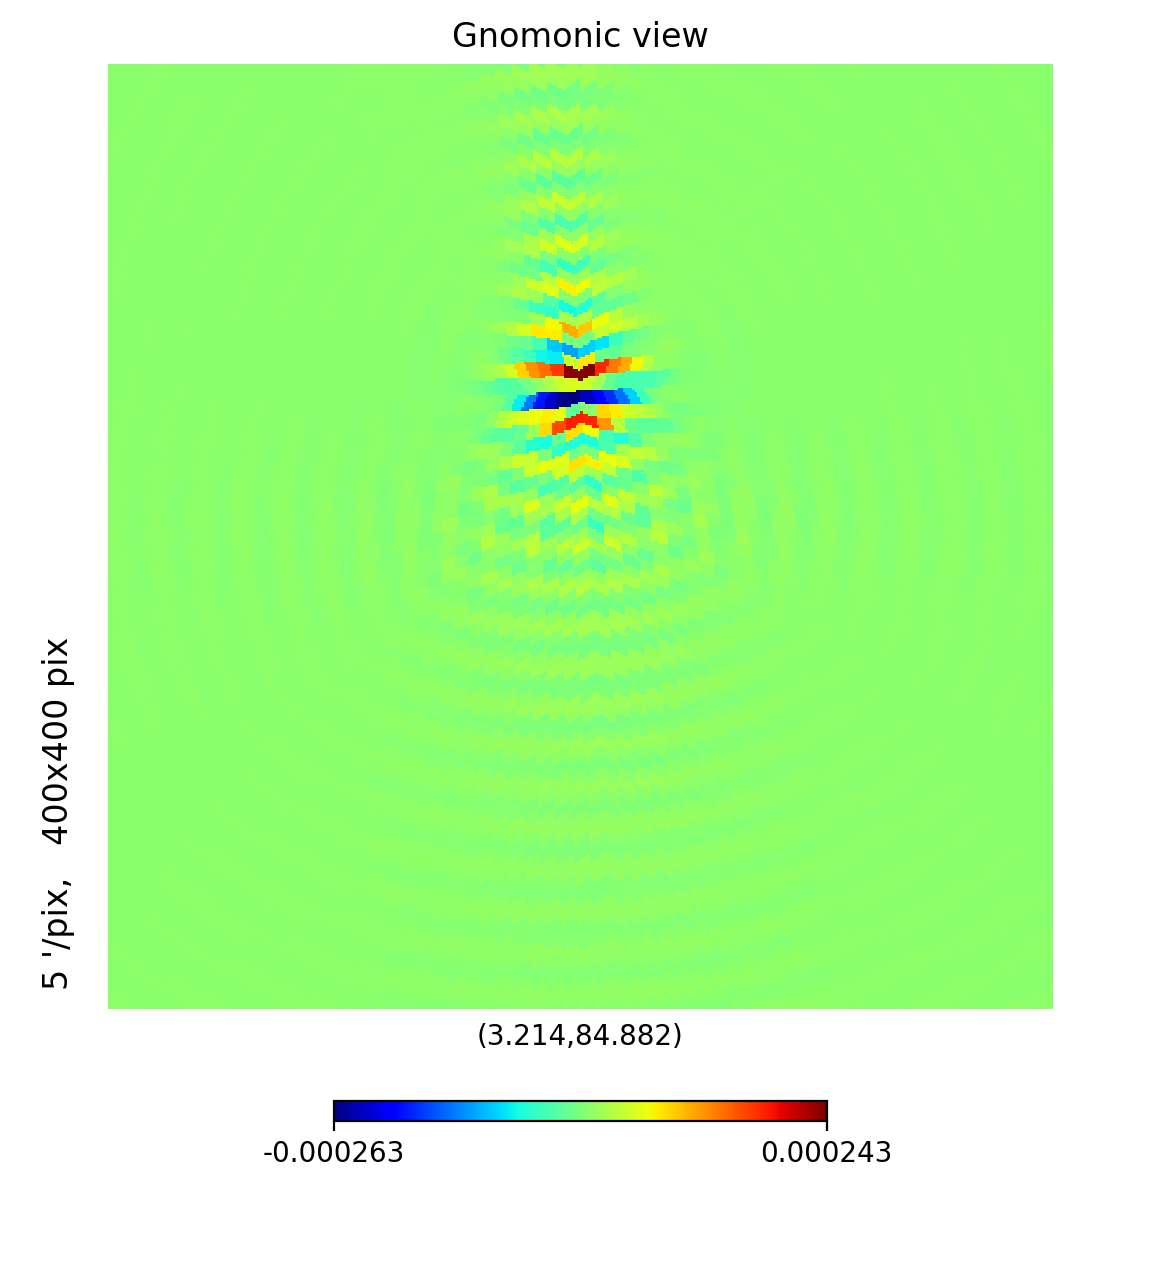

In [344]:
h.gnomview(tebq[1]+mr,rot=(phi,90-theta),xsize=400,reso=5)

In [385]:
tqu[pix]

NameError: name 'pix' is not defined